# Importations

In [ ]:
!pip install boruta
!pip install shap==0.40.0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import shap

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CoursITS3/VTI - Mellouk/article final/Heart_disease_cleveland_new.csv")#change the path
# Resetting the index of the DataFrame
df = df.reset_index(drop=True)

# Preprocessing steps
# Splitting the dataset into features and target variable
X=df.iloc[:,0:13]
y=df['target']

feature_names = list(df.columns.values) #13 features
feature_names.pop()

'target'

# Standardizing the features

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test set without Botura

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature selection with Boruta

In [ ]:
def boruta_feature_selection(X, y, n_estimators=100, max_iter=100, random_state=None):
    # Step 1: Initialize variables
    n_features = X.shape[1]
    feature_importances = np.zeros(n_features)
    accepted_features = np.zeros(n_features, dtype=bool)

    # Random forest model
    model = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced', max_depth=5, random_state=random_state)

    # Iterative process
    for iteration in range(max_iter):
        # Step 2: Create shadow features
        X_shadow = np.apply_along_axis(np.random.permutation, 0, X)
        X_boruta = np.hstack((X, X_shadow))

        # Step 3: Train the model
        model.fit(X_boruta, y)

        # Step 4: Evaluate the feature importance and get the maximum of shadow features
        feature_importance = model.feature_importances_[:n_features]
        shadow_max = np.amax(model.feature_importances_[n_features:])

        # Update feature importance history
        feature_importances += feature_importance

        # Step 5: Decide if a feature is significant
        hits = feature_importance > shadow_max

        # Step 6: Update accepted features if a feature has hit more often than a random threshold
        accepted_features |= hits

    # Step 7: Confirm the feature selection process
    # Features that hit more often than random are accepted
    accepted_features = feature_importances / max_iter > np.median(feature_importances / max_iter)

    return accepted_features

# Application de la sélection des caractéristiques Boruta
accepted_mask = boruta_feature_selection(X_scaled, y, max_iter=100, random_state=42)

# Convertir les indices des caractéristiques sélectionnées en entiers
chosen_features_indices = [i for i in range(len(accepted_mask)) if accepted_mask[i]]

# Sélectionner les caractéristiques du DataFrame
X_selected = X.iloc[:, chosen_features_indices]

# Affichage des caractéristiques sélectionnées
print(X_selected)


     age  cp  thalach  oldpeak  ca  thal
0     63   0      150      2.3   0     2
1     67   3      108      1.5   3     1
2     67   3      129      2.6   2     3
3     37   2      187      3.5   0     1
4     41   1      172      1.4   0     1
..   ...  ..      ...      ...  ..   ...
298   45   0      132      1.2   0     3
299   68   3      141      3.4   2     3
300   57   3      115      1.2   1     3
301   57   1      174      0.0   1     1
302   38   2      173      0.0   0     1

[303 rows x 6 columns]


In [ ]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_selected, y, test_size=0.3, random_state=42)
print(X_test_filtered)

     age  cp  thalach  oldpeak  ca  thal
179   53   2      173      0.0   3     1
228   54   3      108      0.0   1     1
111   56   3      144      1.2   1     1
246   58   3      156      0.1   1     3
60    51   3      142      1.2   0     3
..   ...  ..      ...      ...  ..   ...
250   57   3      126      1.5   0     2
19    49   1      171      0.6   0     1
143   64   2      131      1.8   0     3
79    58   3      111      0.8   0     3
144   58   2      154      0.6   0     3

[91 rows x 6 columns]


# Article codes

## Logistic regression

### With Botura

Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=500
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=1000
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=2000
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=3000
accuracy : 0.5384615384615384
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=500
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=1000
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=2000
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=3000
accuracy : 0.5384615384615384
Testing learning_rate=1e-06, regularization_strength=0.01, epoch=500
accuracy : 0.5274725274725275
Testing learning_rate=1e-06, regularization_strength=0.01, epoch=1000
accuracy : 0.52747252

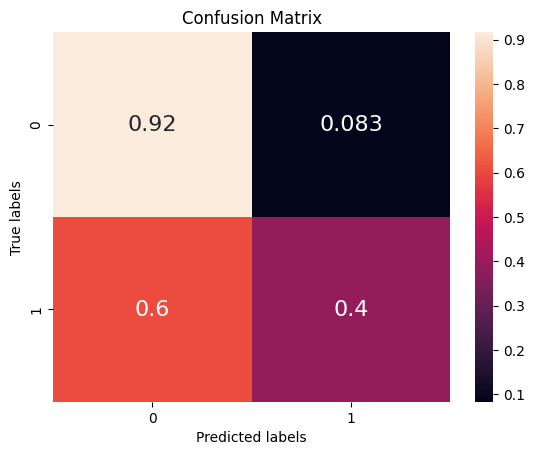

In [ ]:
import numpy as np
best_accuracy = 0
best_params = {}

learning_rate = [0.000001,0.00001,0.0001,0.001]
regularization_strength = [0.0001,0.001,0.01]
max_iter = [500,1000,2000,3000]

class LogisticRegression:
    def __init__(self, learning_rate=0.001, iterations=1000, regularization_strength=0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.regularization_strength = regularization_strength

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Initialize weights and bias
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Gradient Descent
        for i in range(self.iterations):
            # Calculate model predictions
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)

            # Calculate the gradient
            error = predictions - y
            dw = np.dot(X.T, error) / len(y) + self.regularization_strength * self.weights
            db = np.sum(error) / len(y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        # Calculate probabilities
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        # Convert probabilities to binary output
        probabilities = self.predict_proba(X)
        return [1 if i > threshold else 0 for i in probabilities]

for learning_rate, regularization_strength, max_iter in itertools.product(learning_rate, regularization_strength, max_iter):
    print(f"Testing learning_rate={learning_rate}, regularization_strength={regularization_strength}, epoch={max_iter}")
    model = LogisticRegression(learning_rate=learning_rate, iterations=max_iter, regularization_strength=regularization_strength)
    model.fit(X_train_filtered, y_train_filtered)
    y_pred = model.predict(X_test_filtered)

    accuracy = accuracy_score(y_test_filtered, y_pred)
    print('accuracy :', accuracy)

    # Mettre à jour les meilleurs paramètres si nécessaire
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'lr': learning_rate,
            'regularization_strength': regularization_strength,
            'epoch': max_iter
        }

print("Best Parameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy}")


model = LogisticRegression(learning_rate=1e-05, iterations=1000, regularization_strength=0.0001)
model.fit(X_train_filtered, y_train_filtered)
y_pred = model.predict(X_test_filtered)

# Evaluation
print(classification_report(y_test_filtered, y_pred))
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred, average='macro')
recall = recall_score(y_test_filtered, y_pred, average='macro')
f1 = f1_score(y_test_filtered, y_pred, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test_filtered, y_pred, normalize='true')
sns.heatmap(conf_mat,annot=True, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



### Without Botura

Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=500
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=1000
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=2000
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=3000
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=500
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=1000
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=2000
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.001, epoch=3000
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.01, epoch=500
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.01, epoch=1000
accuracy : 0.88524590

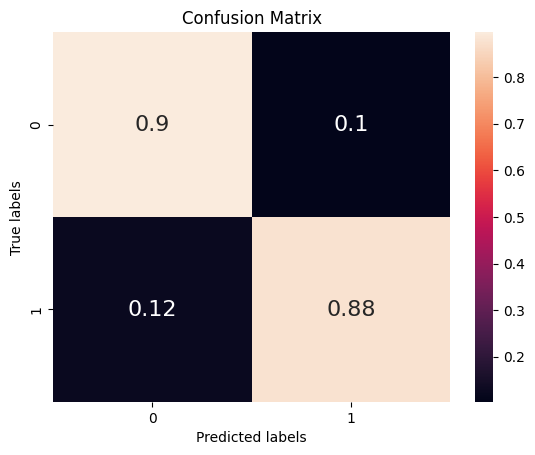

Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=500
accuracy : 0.8852459016393442
Testing learning_rate=1e-06, regularization_strength=0.0001, epoch=1000


In [ ]:
import numpy as np

best_accuracy = 0
best_params = {}

learning_rate = [0.000001,0.00001,0.0001,0.001]
regularization_strength = [0.0001,0.001,0.01]
max_iter = [500,1000,2000,3000]

class LogisticRegression:
    def __init__(self, learning_rate=0.001, iterations=1000, regularization_strength=0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.regularization_strength = regularization_strength

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Initialize weights and bias
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Gradient Descent
        for i in range(self.iterations):
            # Calculate model predictions
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)

            # Calculate the gradient
            error = predictions - y
            dw = np.dot(X.T, error) / len(y) + self.regularization_strength * self.weights
            db = np.sum(error) / len(y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        # Calculate probabilities
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        # Convert probabilities to binary output
        probabilities = self.predict_proba(X)
        return [1 if i > threshold else 0 for i in probabilities]


for learning_rate, regularization_strength, max_iter in itertools.product(learning_rate, regularization_strength, max_iter):
    print(f"Testing learning_rate={learning_rate}, regularization_strength={regularization_strength}, epoch={max_iter}")
    model = LogisticRegression(learning_rate=learning_rate, iterations=max_iter, regularization_strength=regularization_strength)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    # Mettre à jour les meilleurs paramètres si nécessaire
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'lr': learning_rate,
            'regularization_strength': regularization_strength,
            'epoch': max_iter
        }

print("Best Parameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy}")


modelLogistic = LogisticRegression(learning_rate=1e-05, iterations=1000, regularization_strength=0.0001)
modelLogistic.fit(X_train, y_train)
y_pred = modelLogistic.predict(X_test)


# Evaluation
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


### My method

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        48
           1       0.78      0.91      0.84        43

    accuracy                           0.84        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.84      0.84      0.83        91



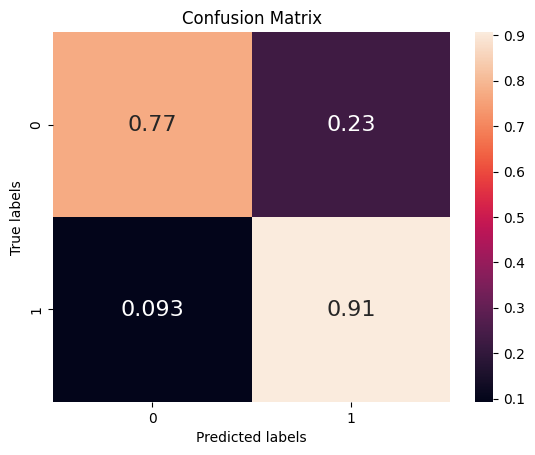

In [ ]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

logModel = SKLogisticRegression(solver='lbfgs', max_iter=10000)
logModel.fit(X_train_filtered, y_train_filtered)
predictions = logModel.predict(X_test_filtered)

# Evaluation
print(classification_report(y_test_filtered, predictions))  # Use 'predictions' instead of 'y_pred'
accuracy = accuracy_score(y_test_filtered, predictions)
precision = precision_score(y_test_filtered, predictions, average='macro')
recall = recall_score(y_test_filtered, predictions, average='macro')
f1 = f1_score(y_test_filtered, predictions, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test_filtered, predictions, normalize='true')
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


### Interpretation

Expected Value: 0.0826790177258222


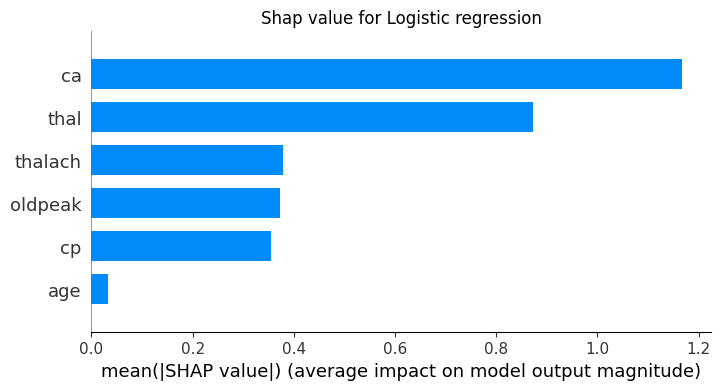

In [ ]:
feature_names = ['age', 'cp', 'thalach', 'oldpeak', 'ca' ,'thal']
class_names=['Class 0', 'Class 1']

# Créez un explainer SHAP pour votre modèle
explainer = shap.Explainer(logModel, X_train_filtered)

shap_values = explainer.shap_values(X_test_filtered)
print('Expected Value:', explainer.expected_value)

shap.initjs()
shap.summary_plot(shap_values, X_test_filtered, plot_type="bar", show=False)
plt.title("Shap value for Logistic regression")
plt.show()

## Decision Tree

### With Botura

In [ ]:
X_train_filtered = X_train_filtered.to_numpy()

Testing max_depth=2, num_samples_per_leaf=2
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=3
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=4
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=5
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=10
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=15
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=20
Accuracy: 0.5274725274725275
Testing max_depth=2, num_samples_per_leaf=30
Accuracy: 0.5274725274725275
Testing max_depth=3, num_samples_per_leaf=2
Accuracy: 0.5274725274725275
Testing max_depth=3, num_samples_per_leaf=3
Accuracy: 0.5274725274725275
Testing max_depth=3, num_samples_per_leaf=4
Accuracy: 0.5274725274725275
Testing max_depth=3, num_samples_per_leaf=5
Accuracy: 0.5274725274725275
Testing max_depth=3, num_samples_per_leaf=10
Accuracy: 0.5274725274725275
Testing max_depth=3, num_samples_per_leaf=15
A

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.53      1.00      0.69        48
           1       0.00      0.00      0.00        43

    accuracy                           0.53        91
   macro avg       0.26      0.50      0.35        91
weighted avg       0.28      0.53      0.36        91



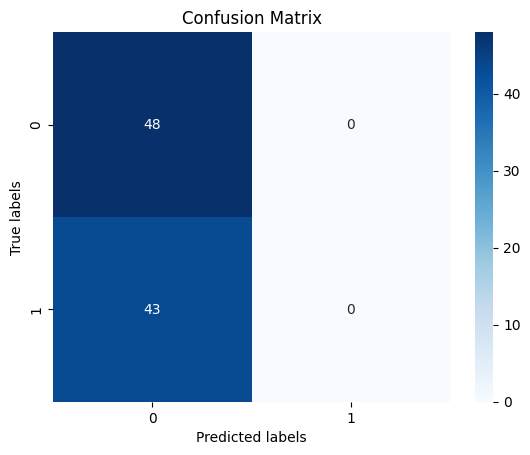

In [ ]:
import numpy as np

class DecisionTreeNode:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def gini_impurity(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

def best_split(X, y, num_samples_per_leaf):
    m, n = X.shape
    if m <= num_samples_per_leaf:
        return None, None

    best_gini = 1.0
    best_idx, best_thr = None, None

    for idx in range(n):
        thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
        num_left = [0] * len(np.unique(y))
        num_right = [np.sum(y == c) for c in np.unique(y)]

        for i in range(1, m):
            c = classes[i - 1]
            num_left[c] += 1
            num_right[c] -= 1

            gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in np.unique(y))
            gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in np.unique(y))
            gini = (i * gini_left + (m - i) * gini_right) / m

            if i >= num_samples_per_leaf and m - i >= num_samples_per_leaf and gini < best_gini:
                best_gini = gini
                best_idx = idx
                best_thr = (thresholds[i - 1] + thresholds[i]) / 2

    return best_idx, best_thr

def build_tree(X, y, depth=0, max_depth=None, num_samples_per_leaf=1):
    if len(y) == 0:
        return None  # Retourne None si y est vide

    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = DecisionTreeNode(
        gini=gini_impurity(y),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )

    if depth < max_depth:
        # Le reste du code reste inchangé
        idx, thr = best_split(X, y, num_samples_per_leaf)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]

            node.feature_index = idx
            node.threshold = thr
            node.left = build_tree(X_left, y_left, depth + 1, max_depth, num_samples_per_leaf)
            node.right = build_tree(X_right, y_right, depth + 1, max_depth, num_samples_per_leaf)

    return node

def predict(tree, X):
    predictions = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        node = tree
        while node.left:
            if X[i, node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        predictions[i] = node.predicted_class
    return predictions

def fit_tree(X, y, max_depth=None, num_samples_per_leaf=1):
    return build_tree(X, y, max_depth=max_depth, num_samples_per_leaf=num_samples_per_leaf)

best_accuracy = 0
best_params = {}
max_depth_options = [2, 3, 4, 5, 10, 15, 20, 30]
min_samples_leaf_options = [2, 3, 4, 5, 10, 15, 20, 30]

for max_depth, num_samples_per_leaf in itertools.product(max_depth_options, min_samples_leaf_options):
    print(f"Testing max_depth={max_depth}, num_samples_per_leaf={num_samples_per_leaf}")
    tree = fit_tree(X_train_filtered, y_train_filtered, max_depth=max_depth, num_samples_per_leaf=num_samples_per_leaf)
    y_pred = predict(tree, X_test_filtered)

    accuracy = accuracy_score(y_test_filtered, y_pred)
    print('Accuracy:', accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'max_depth': max_depth,
            'num_samples_per_leaf': num_samples_per_leaf
        }

print("Best Parameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy}")

tree = fit_tree(X_train_filtered, y_train_filtered, max_depth=5, num_samples_per_leaf=5)
y_pred = predict(tree, X_test_filtered)

# Evaluation
print(classification_report(y_test_filtered, y_pred))
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred, average='macro')
recall = recall_score(y_test_filtered, y_pred, average='macro')
f1 = f1_score(y_test_filtered, y_pred, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test_filtered, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


### Without Botura

Testing max_depth=2, num_samples_per_leaf=2
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=3
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=4
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=5
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=10
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=15
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=20
Accuracy: 0.47540983606557374
Testing max_depth=2, num_samples_per_leaf=30
Accuracy: 0.47540983606557374
Testing max_depth=3, num_samples_per_leaf=2
Accuracy: 0.47540983606557374
Testing max_depth=3, num_samples_per_leaf=3
Accuracy: 0.47540983606557374
Testing max_depth=3, num_samples_per_leaf=4
Accuracy: 0.47540983606557374
Testing max_depth=3, num_samples_per_leaf=5
Accuracy: 0.47540983606557374
Testing max_depth=3, num_samples_per_leaf=10
Accuracy: 0.47540983606557374
Testing max_depth=3, num_samples_

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.48      1.00      0.64        29
           1       0.00      0.00      0.00        32

    accuracy                           0.48        61
   macro avg       0.24      0.50      0.32        61
weighted avg       0.23      0.48      0.31        61



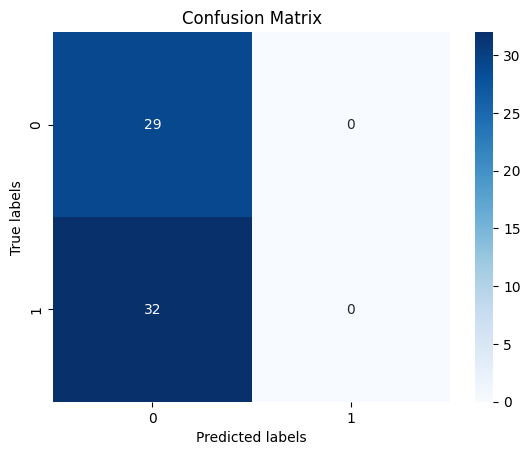

In [ ]:
import numpy as np

class DecisionTreeNode:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def gini_impurity(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

def best_split(X, y, num_samples_per_leaf):
    m, n = X.shape
    if m <= num_samples_per_leaf:
        return None, None

    best_gini = 1.0
    best_idx, best_thr = None, None

    for idx in range(n):
        thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
        num_left = [0] * len(np.unique(y))
        num_right = [np.sum(y == c) for c in np.unique(y)]

        for i in range(1, m):
            c = classes[i - 1]
            num_left[c] += 1
            num_right[c] -= 1

            gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in np.unique(y))
            gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in np.unique(y))
            gini = (i * gini_left + (m - i) * gini_right) / m

            if i >= num_samples_per_leaf and m - i >= num_samples_per_leaf and gini < best_gini:
                best_gini = gini
                best_idx = idx
                best_thr = (thresholds[i - 1] + thresholds[i]) / 2

    return best_idx, best_thr

def build_tree(X, y, depth=0, max_depth=None, num_samples_per_leaf=1):
    if len(y) == 0:
        return None  # Retourne None si y est vide

    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = DecisionTreeNode(
        gini=gini_impurity(y),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )

    if depth < max_depth:
        # Le reste du code reste inchangé
        idx, thr = best_split(X, y, num_samples_per_leaf)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]

            node.feature_index = idx
            node.threshold = thr
            node.left = build_tree(X_left, y_left, depth + 1, max_depth, num_samples_per_leaf)
            node.right = build_tree(X_right, y_right, depth + 1, max_depth, num_samples_per_leaf)

    return node

def predict(tree, X):
    predictions = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        node = tree
        while node.left:
            if X[i, node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        predictions[i] = node.predicted_class
    return predictions

def fit_tree(X, y, max_depth=None, num_samples_per_leaf=1):
    return build_tree(X, y, max_depth=max_depth, num_samples_per_leaf=num_samples_per_leaf)

best_accuracy = 0
best_params = {}
max_depth_options = [2, 3, 4, 5, 10, 15, 20, 30]
min_samples_leaf_options = [2, 3, 4, 5, 10, 15, 20, 30]

for max_depth, num_samples_per_leaf in itertools.product(max_depth_options, min_samples_leaf_options):
    print(f"Testing max_depth={max_depth}, num_samples_per_leaf={num_samples_per_leaf}")
    tree = fit_tree(X_train, y_train, max_depth=max_depth, num_samples_per_leaf=num_samples_per_leaf)
    y_pred = predict(tree, X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'max_depth': max_depth,
            'num_samples_per_leaf': num_samples_per_leaf
        }

print("Best Parameters Found:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy}")

tree = fit_tree(X_train, y_train, max_depth=5, num_samples_per_leaf=5)
y_pred = predict(tree, X_test)

# Evaluation
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


### My code

Meilleurs hyperparamètres trouvés : {'max_depth': 10, 'min_samples_leaf': 5}
              precision    recall  f1-score   support

           0       0.88      0.79      0.84        48
           1       0.79      0.88      0.84        43

    accuracy                           0.84        91
   macro avg       0.84      0.84      0.84        91
weighted avg       0.84      0.84      0.84        91



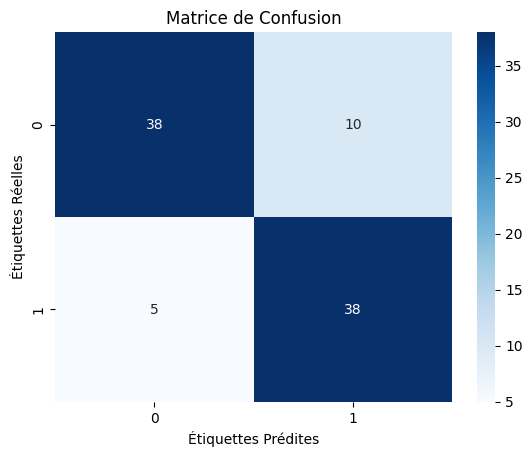

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

# Prétraitement des données : Assurez-vous d'avoir vos données d'entraînement et de test X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered

# Sous-échantillonnage de la classe majoritaire
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_filtered, y_train_filtered)

# Définir les hyperparamètres à rechercher
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}

# Créer un classificateur d'arbre de décision
clf = DecisionTreeClassifier()

# Utiliser la validation croisée pour ajuster les hyperparamètres
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# Meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_

# Créer un arbre de décision avec les meilleurs hyperparamètres
best_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])
best_tree.fit(X_train_resampled, y_train_resampled)

# Prédictions sur les données de test
y_pred = best_tree.predict(X_test_filtered)

# Évaluation
print("Meilleurs hyperparamètres trouvés :", best_params)
print(classification_report(y_test_filtered, y_pred))
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred, average='macro')
recall = recall_score(y_test_filtered, y_pred, average='macro')
f1 = f1_score(y_test_filtered, y_pred, average='macro')

# Matrice de confusion
conf_mat = confusion_matrix(y_test_filtered, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Étiquettes Prédites')
plt.ylabel('Étiquettes Réelles')
plt.show()


### Interpretation

Expected Value: [0.48742857 0.51257143]


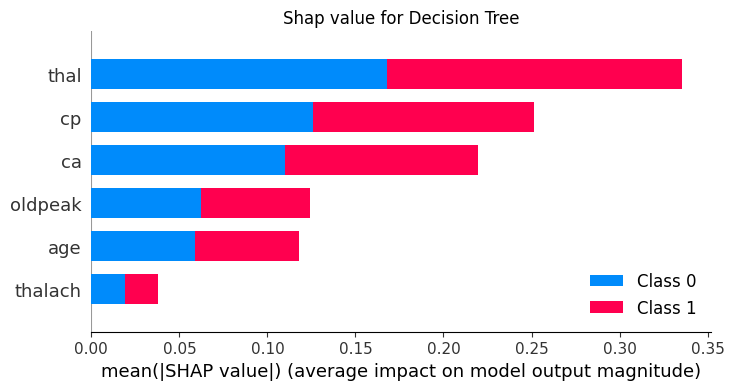

In [ ]:
# Créez un explainer SHAP pour votre modèle
explainer = shap.Explainer(best_tree, X_train_filtered)

shap_values = explainer.shap_values(X_test_filtered)
print('Expected Value:', explainer.expected_value)

shap.initjs()
shap.summary_plot(shap_values, X_test_filtered, plot_type="bar", show=False)
plt.title("Shap value for Decision Tree")
plt.show()

## SVM

### With Botura

In [ ]:
# Convert X_train_filtered to a NumPy array
X_train_filtered = X_train_filtered.to_numpy()
y_train_filtered = y_train_filtered.to_numpy()

Testing learning_rate=1e-05, epoch=500, C=0.1, kernel=linear
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=0.1, kernel=poly
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=0.1, kernel=sigmoid
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=1, kernel=linear
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=1, kernel=poly
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=1, kernel=sigmoid
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=10, kernel=linear
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=10, kernel=poly
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=10, kernel=sigmoid
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=100, kernel=linear
accuracy : 0.4725274725274725
Testing learning_rate=1e-05, epoch=500, C=100, kernel=poly
accuracy : 0.4725274725274725
Testing learn

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

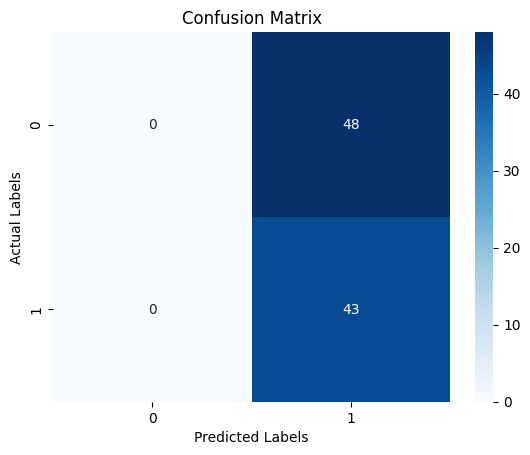

In [ ]:
import numpy as np

class SupportVectorMachine:
    def __init__(self, learning_rate=0.01, num_epochs=1000, C=1.0, kernel='linear', degree=3, gamma=1.0, alpha=1.0, class_weight=None):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.C = C
        self.kernel = kernel
        self.degree = degree  # Degree for polynomial kernel
        self.gamma = gamma    # Gamma for RBF kernel
        self.alpha = alpha
        self.class_weight = class_weight  # Class weights

    def fit(self, X, y):
        if not isinstance(X, np.ndarray):
            raise ValueError("X should be a NumPy array.")

        if not isinstance(y, np.ndarray):
            raise ValueError("y should be a NumPy array.")

        if X.shape[0] != y.shape[0]:
            raise ValueError("Number of samples in X and y must match.")

        # Initialize weights and bias
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Slack variables (initialize to zero)
        slack_variables = np.zeros(X.shape[0])

        # Gradient Descent for training
        for epoch in range(self.num_epochs):
            for i, x in enumerate(X):
                # Calculate decision boundary value
                decision_boundary = np.dot(x, self.weights) + self.bias

                # Calculate hinge loss (with regularization)
                if self.class_weight is not None:
                    loss = max(0, 1 - y[i] * decision_boundary) + (1 / (2 * self.C)) * np.dot(self.weights, self.weights)
                else:
                    loss = max(0, 1 - y[i] * decision_boundary)  # No regularization

                # Update weights, bias, and slack variables
                if loss > 0:
                    if self.class_weight is not None:
                        weight = self.class_weight[y[i]] if self.class_weight else 1.0
                        self.weights -= self.learning_rate * (self.weights - self.C * y[i] * x) * weight
                        self.bias -= self.learning_rate * self.C * y[i] * weight
                    else:
                        self.weights -= self.learning_rate * (self.weights - self.C * y[i] * x)
                        self.bias -= self.learning_rate * self.C * y[i]
                    slack_variables[i] += self.learning_rate

        # Store slack variables for later use (if needed)
        self.slack_variables = slack_variables


    def predict(self, X):
      if self.kernel == 'linear':
          return np.sign(np.dot(X, self.weights) + self.bias)
      elif self.kernel == 'poly':
          prediction = np.sign(np.dot(np.power(X, self.degree), self.weights) + self.bias)
          return prediction
      elif self.kernel == 'sigmoid':
          prediction = np.sign(np.tanh(self.alpha * np.dot(X, self.weights) + self.bias))
          return prediction



# Define a list of hyperparameters to try
learning_rates = [0.00001,0.0001,0.001,0.01]
num_epochs_values = [500, 1000, 2000]
C_values = [0.1, 1, 10, 100]
kernel_values = ['linear', 'poly', 'sigmoid']
class_weights = {0: 2.0, 1: 1.0}  # Give more weight to class 0

best_accuracy = 0
best_hyperparameters = None

# Iterate through hyperparameter combinations
for learning_rate in learning_rates:
    for num_epochs in num_epochs_values:
        for C in C_values:
            for kernel in kernel_values:
                print(f"Testing learning_rate={learning_rate}, epoch={num_epochs}, C={C}, kernel={kernel}")
                # Create and train SVM using the current hyperparameters
                svm = SupportVectorMachine(learning_rate=learning_rate, num_epochs=num_epochs, C=C, kernel=kernel, class_weight=class_weights)
                svm.fit(X_train_filtered, y_train_filtered)

                # Validate the model on the validation set
                y_test_pred = svm.predict(X_test_filtered)
                test_accuracy = accuracy_score(y_test_filtered, y_test_pred)
                print('accuracy :', test_accuracy)

                # Check if this combination of hyperparameters is the best so far
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_hyperparameters = {
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'C': C,
                        'kernel': kernel
                    }

# Train the final model using the best hyperparameters
final_svm = SupportVectorMachine(learning_rate=best_hyperparameters['learning_rate'], num_epochs=best_hyperparameters['num_epochs'], C=best_hyperparameters['C'], kernel=best_hyperparameters['kernel'])
final_svm.fit(X_train_filtered, y_train_filtered)

# Test predictions on the filtered test data
y_pred = final_svm.predict(X_test_filtered)

# Evaluation
print("Best Hyperparameters:", best_hyperparameters)
print(classification_report(y_test_filtered, y_pred))
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred, average='macro')
recall = recall_score(y_test_filtered, y_pred, average='macro')
f1 = f1_score(y_test_filtered, y_pred, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test_filtered, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

### Without Botura

In [ ]:
# Convert X_train to a NumPy array

y_train = y_train.to_numpy()

Testing learning_rate=0.01, epoch=500, C=0.1, kernel=linear
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=0.1, kernel=poly
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=0.1, kernel=rbf
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=1, kernel=linear
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=1, kernel=poly
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=1, kernel=rbf
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=10, kernel=linear
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=10, kernel=poly
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=500, C=10, kernel=rbf
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=1000, C=0.1, kernel=linear
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=1000, C=0.1, kernel=poly
accuracy : 0.5245901639344263
Testing learning_rate=0.01, epoch=

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

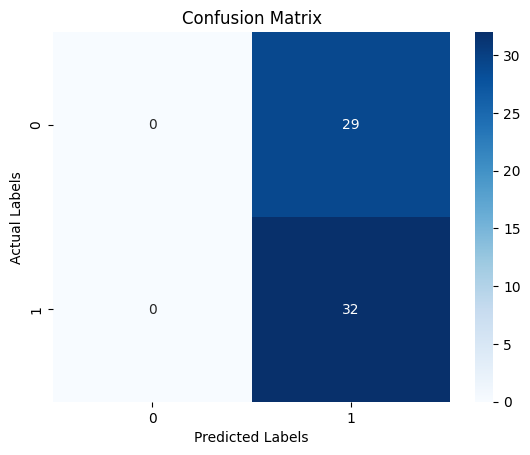

In [ ]:
import numpy as np

class SupportVectorMachine:
    def __init__(self, learning_rate=0.01, num_epochs=1000, C=1.0, kernel='linear'):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.C = C
        self.kernel = kernel

    def fit(self, X, y):
      if not isinstance(X, np.ndarray):
          raise ValueError("X should be a NumPy array.")

      if not isinstance(y, np.ndarray):
          raise ValueError("y should be a NumPy array.")

      if X.shape[0] != y.shape[0]:
          raise ValueError("Number of samples in X and y must match.")

      # Initialize weights and bias
      self.weights = np.zeros(X.shape[1])
      self.bias = 0

      # Gradient Descent for training
      for epoch in range(self.num_epochs):
          for i, x in enumerate(X):
              # Calculate decision boundary value
              decision_boundary = np.dot(x, self.weights) + self.bias

              # Update weights and bias if misclassified
              if y[i] * decision_boundary <= 1:
                  self.weights += self.learning_rate * (y[i] * x - 2 * self.weights)
                  self.bias += self.learning_rate * y[i]


    def predict(self, X):
        return np.sign(np.dot(X, self.weights) + self.bias)


# Define a list of hyperparameters to try
learning_rates = [0.01, 0.1, 1]
num_epochs_values = [500, 1000, 2000]
C_values = [0.1, 1, 10]
kernel_values = ['linear', 'poly', 'rbf']

best_accuracy = 0
best_hyperparameters = None

# Iterate through hyperparameter combinations
for learning_rate in learning_rates:
    for num_epochs in num_epochs_values:
        for C in C_values:
            for kernel in kernel_values:
                print(f"Testing learning_rate={learning_rate}, epoch={num_epochs}, C={C}, kernel={kernel}")
                # Create and train SVM using the current hyperparameters
                svm = SupportVectorMachine(learning_rate=learning_rate, num_epochs=num_epochs, C=C, kernel=kernel)
                svm.fit(X_train, y_train)

                # Validate the model on the validation set
                y_test_pred = svm.predict(X_test)
                test_accuracy = accuracy_score(y_test, y_test_pred)
                print('accuracy :', test_accuracy)

                # Check if this combination of hyperparameters is the best so far
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_hyperparameters = {
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'C': C,
                        'kernel': kernel
                    }

# Train the final model using the best hyperparameters
final_svm = SupportVectorMachine(learning_rate=best_hyperparameters['learning_rate'], num_epochs=best_hyperparameters['num_epochs'], C=best_hyperparameters['C'], kernel=best_hyperparameters['kernel'])
final_svm.fit(X_train, y_train)

# Test predictions on the filtered test data
y_pred = final_svm.predict(X_test)

# Evaluation
print("Best Hyperparameters:", best_hyperparameters)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

### Mycode

Meilleurs paramètres trouvés :
{'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Accuracy: 0.8681318681318682
Precision: 0.8297872340425532
Recall: 0.9069767441860465
F1 Score: 0.8666666666666666
Confusion Matrix:


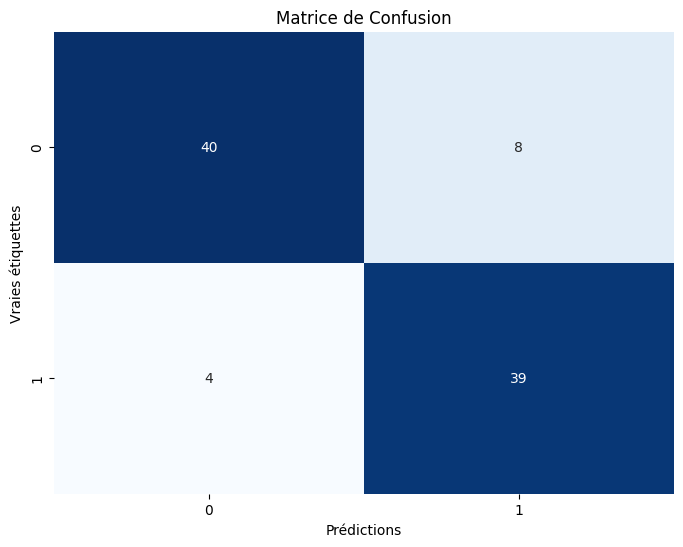

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        48
           1       0.83      0.91      0.87        43

    accuracy                           0.87        91
   macro avg       0.87      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



In [ ]:
# Création d'un pipeline avec standardisation et SVM
pipeline = make_pipeline(StandardScaler(), SVC())

# Définition de la grille des hyperparamètres à tester
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

# Recherche en grille avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')  # Utilisation de la F1-score comme métrique de scoring
grid_search.fit(X_train_filtered, y_train_filtered.ravel())

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Performances du meilleur modèle
y_pred_svm = best_model.predict(X_test_filtered)
accuracy = accuracy_score(y_test_filtered, y_pred_svm)
precision = precision_score(y_test_filtered, y_pred_svm)
recall = recall_score(y_test_filtered, y_pred_svm)
f1 = f1_score(y_test_filtered, y_pred_svm)
confusion = confusion_matrix(y_test_filtered, y_pred_svm)
report = classification_report(y_test_filtered, y_pred_svm)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(report)





### Interpretation

Expected Value: -50.722297255160704


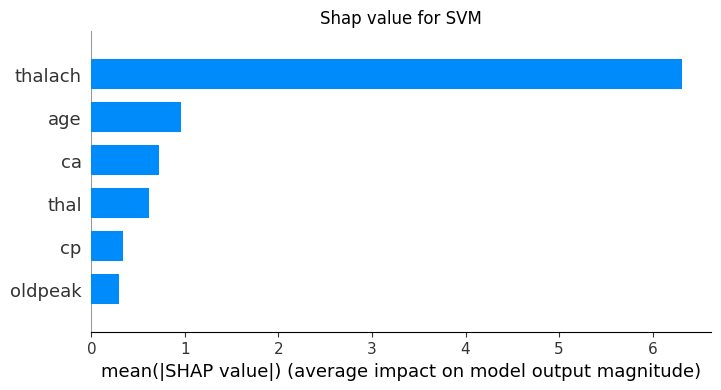

In [ ]:
# Extract the best SVM model from the pipeline
best_svm_model = best_model.named_steps['svc']

# Create a SHAP explainer for your model
explainer = shap.Explainer(best_svm_model, X_train_filtered)

shap_values = explainer.shap_values(X_test_filtered)
print('Expected Value:', explainer.expected_value)

shap.initjs()
shap.summary_plot(shap_values, X_test_filtered, plot_type="bar", show=False)
plt.title("Shap value for SVM")
plt.show()

## XgBoost

### With Botura

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Accuracy: 0.8241758241758241
Precision: 0.8305805805805806
Recall: 0.8200096899224807
F1 Score: 0.8215686274509804


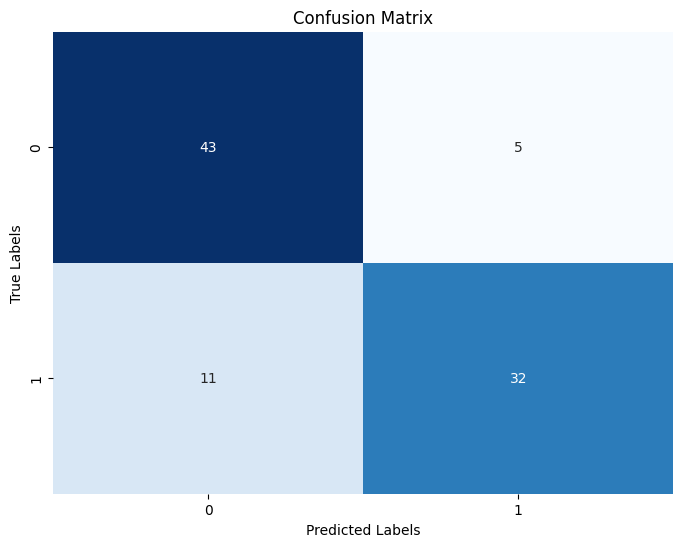

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84        48
           1       0.86      0.74      0.80        43

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91

Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
XGBmodel = XGBClassifier(eval_metric='mlogloss')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=XGBmodel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_filtered, y_train_filtered)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test_filtered)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred, average='macro')
recall = recall_score(y_test_filtered, y_pred, average='macro')
f1 = f1_score(y_test_filtered, y_pred, average='macro')
confusion = confusion_matrix(y_test_filtered, y_pred)
report = classification_report(y_test_filtered, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True,  annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(report)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)


### Without Boruta

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Accuracy: 0.8852459016393442
Precision: 0.8873922413793103
Recall: 0.8873922413793103
F1 Score: 0.8852459016393444


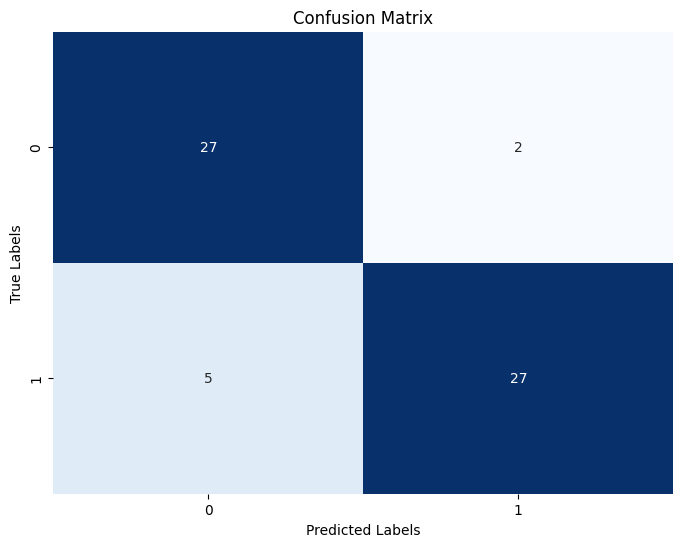

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
XGBmodel = XGBClassifier(eval_metric='mlogloss')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=XGBmodel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred, normalize='true')
report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(report)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)


### My code

Meilleurs hyperparamètres trouvés :  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.8}
Accuracy :  0.8351648351648352
Matrice de confusion :
 [[0.875      0.125     ]
 [0.20930233 0.79069767]]


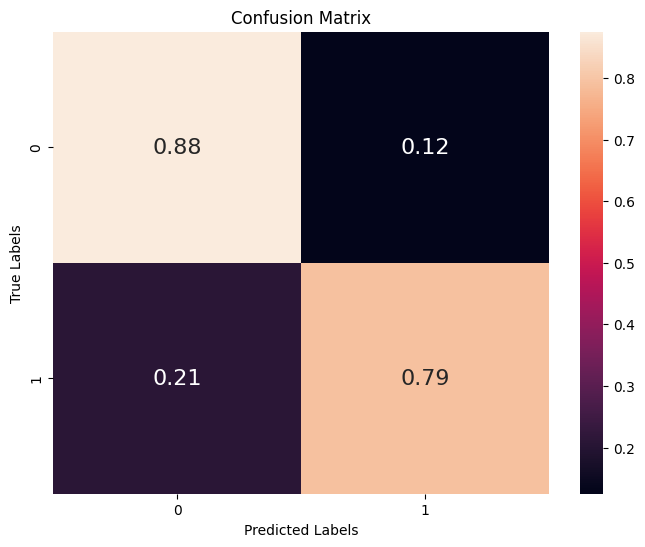

Rapport de classification :
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        48
           1       0.85      0.79      0.82        43

    accuracy                           0.84        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.84      0.83        91



In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à rechercher dans la grille
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'objective': ['binary:logistic']
}

# Créer le modèle XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Créer une instance de GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajuster le modèle aux données d'entraînement filtrées
grid_search.fit(X_train_filtered, y_train_filtered)

# Obtenir les meilleurs hyperparamètres trouvés par la recherche de grille
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres trouvés : ", best_params)

best_model = grid_search.best_estimator_

# Faire des prédictions sur les données de test filtrées avec le modèle optimisé
y_pred = grid_search.predict(X_test_filtered)

# Évaluer les performances du modèle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test_filtered, y_pred)
conf_matrix = confusion_matrix(y_test_filtered, y_pred, normalize='true')
class_report = classification_report(y_test_filtered, y_pred)

print("Accuracy : ", accuracy)

print("Matrice de confusion :\n", conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("Rapport de classification :\n", class_report)


### Interpretation

[14:10:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Expected Value: -0.14219934559857983


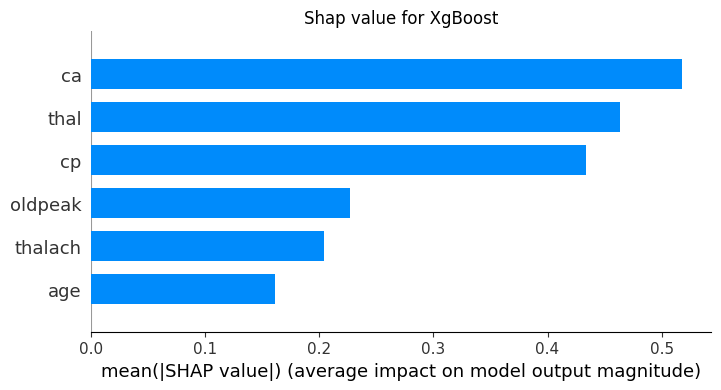

In [ ]:

# Create a SHAP explainer for your model
explainer = shap.Explainer(best_model, X_train_filtered)

shap_values = explainer.shap_values(X_test_filtered)
print('Expected Value:', explainer.expected_value)

shap.initjs()
shap.summary_plot(shap_values, X_test_filtered, plot_type="bar", show=False)
plt.title("Shap value for XgBoost")
plt.show()

## Random Forest

### With Boruta

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Accuracy: 0.8681318681318682
Precision: 0.8717948717948718
Recall: 0.8653100775193798
F1 Score: 0.8668292682926828


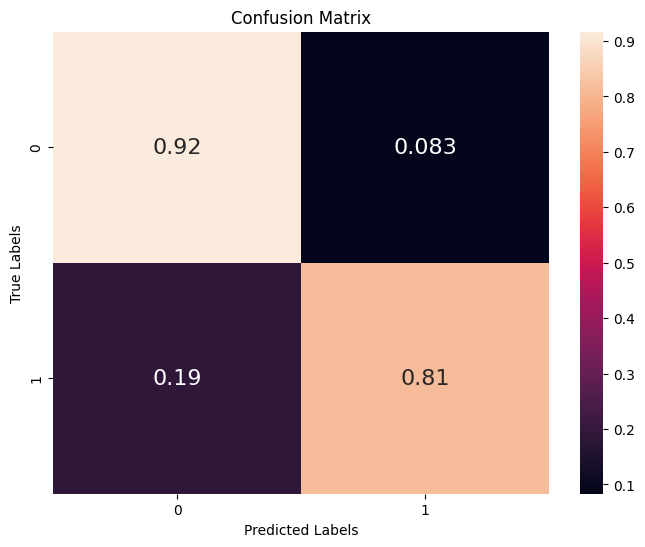

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        48
           1       0.90      0.81      0.85        43

    accuracy                           0.87        91
   macro avg       0.87      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91

Best Hyperparameters:
{'bootstrap': False, 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 20],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4, 20],
    'bootstrap': [True, False],
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_filtered, y_train_filtered)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test_filtered)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred, average='macro')
recall = recall_score(y_test_filtered, y_pred, average='macro')
f1 = f1_score(y_test_filtered, y_pred, average='macro')
confusion = confusion_matrix(y_test_filtered, y_pred, normalize='true')
report = classification_report(y_test_filtered, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(report)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)


### Without Boruta

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Accuracy: 0.8852459016393442
Precision: 0.8873922413793103
Recall: 0.8873922413793103
F1 Score: 0.8852459016393444


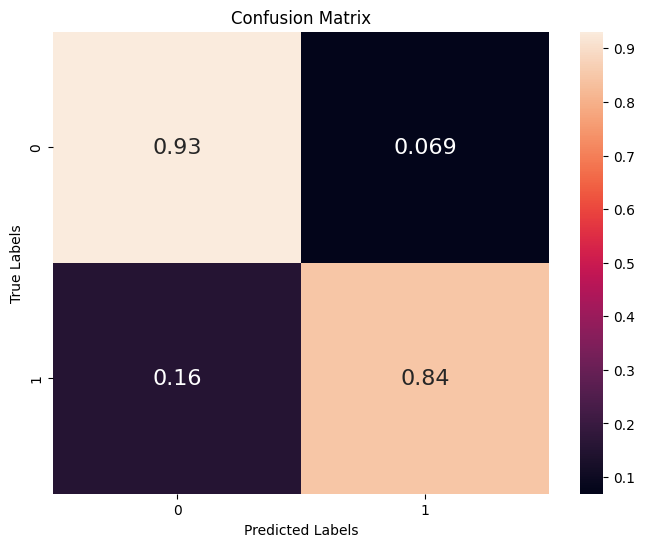

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Best Hyperparameters:
{'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 20],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4, 20],
    'bootstrap': [True, False],
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred, normalize='true')
report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(report)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)


### Interpretation

Expected Value: [0.53530785 0.46469215]


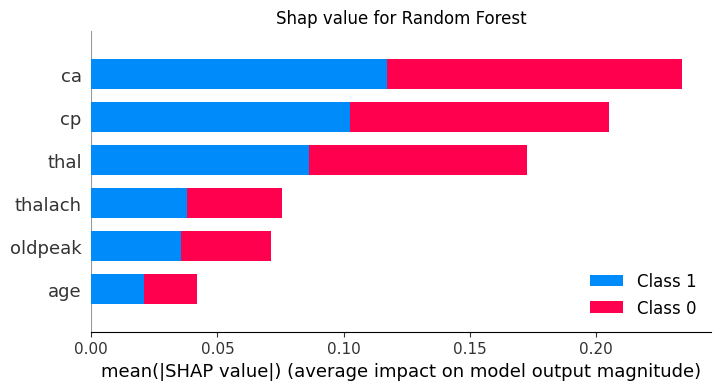

In [ ]:

# Create a SHAP explainer for your model
explainer = shap.Explainer(best_model, X_train_filtered)

shap_values = explainer.shap_values(X_test_filtered)
print('Expected Value:', explainer.expected_value)

shap.initjs()
shap.summary_plot(shap_values, X_test_filtered, plot_type="bar", show=False)
plt.title("Shap value for Random Forest")
plt.show()